In [ ]:
!pip install datasets
!pip install evaluate
!pip install transformers[torch]
!pip install --upgrade safetensors
!pip install -U jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requir

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from datasets import load_dataset
dataset = load_dataset("BothBosu/single-agent-scam-conversations")
dataset = dataset.remove_columns("type")

print(dataset.column_names)
print(len(dataset["train"]))
print(len(dataset["test"]))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1280 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/320 [00:00<?, ? examples/s]

{'train': ['dialogue', 'labels'], 'test': ['dialogue', 'labels']}
1280
320


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = evaluate.load("accuracy")
    precision = evaluate.load("precision")
    recall = evaluate.load("recall")
    f1 = evaluate.load("f1")
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels),
        "precision": precision.compute(predictions=predictions, references=labels, average="weighted"),
        "recall": recall.compute(predictions=predictions, references=labels, average="weighted"),
        "f1": f1.compute(predictions=predictions, references=labels, average="weighted")
    }

### BERT

In [ ]:
import matplotlib.pyplot as plt
from transformers import TrainerCallback, TrainingArguments, TrainerState, TrainerControl, EarlyStoppingCallback

class PlotLossesCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])
            if 'eval_accuracy' in logs and logs['eval_accuracy'] == 1.0:
                control.should_training_stop = True

    def on_train_end(self, args, state, control, **kwargs):
        plt.figure(figsize=(12, 6))
        plt.plot(self.train_losses, label="Training Loss")
        plt.plot(self.eval_losses, label="Validation Loss")
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        if self.train_losses:
            plt.ylim(bottom=0, top=self.train_losses[0])  # Set top limit to the first training loss
        plt.legend()
        plt.title("Training and Validation Loss over Time")
        plt.show()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1280 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.032472,{'accuracy': 0.990625},{'precision': 0.99079754601227},{'recall': 0.990625},{'f1': 0.9906241759529646}
2,No log,0.000182,{'accuracy': 1.0},{'precision': 1.0},{'recall': 1.0},{'f1': 1.0}
3,No log,0.000091,{'accuracy': 1.0},{'precision': 1.0},{'recall': 1.0},{'f1': 1.0}
4,0.036700,0.000060,{'accuracy': 1.0},{'precision': 1.0},{'recall': 1.0},{'f1': 1.0}


Trainer is attempting to log a value of "{'accuracy': 0.990625}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.99079754601227}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.990625}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9906241759529646}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 1.0}" of type <class 'dict'> for key "eval/accuracy" as a 

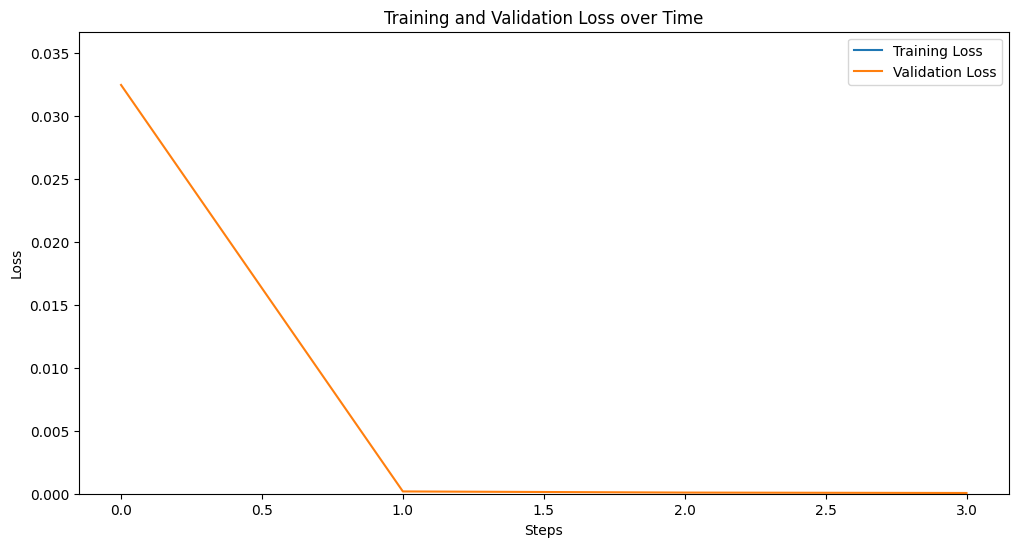

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np

def train_bert():
    bert_tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

    def bert_preprocess_function(examples):
        return bert_tokenizer(examples["dialogue"], truncation=True, padding=True)

    bert_tokenized_dataset = dataset.map(bert_preprocess_function, batched=True)
    bert_data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

    id2label = {0: "NON-SCAM", 1: "SCAM"}
    label2id = {"NON-SCAM": 0, "SCAM": 1}

    model = AutoModelForSequenceClassification.from_pretrained(
        "google-bert/bert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
    )

    training_args = TrainingArguments(
        output_dir="bert-scam-classifier-v1.6",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=10,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=bert_tokenized_dataset['train'],
        eval_dataset=bert_tokenized_dataset['test'],
        tokenizer=bert_tokenizer,
        data_collator=bert_data_collator,
        compute_metrics=compute_metrics,
        callbacks=[
            PlotLossesCallback(),
            EarlyStoppingCallback(early_stopping_threshold=0.01, early_stopping_patience=2)
        ]
    )

    trainer.train()
    trainer.push_to_hub()

train_bert()

### Dataloader for Pytorch

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the dataset from Hugging Face
dataset = load_dataset("BothBosu/scam-dialogue")
dataset = dataset.remove_columns("type")

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the dialogue column
def tokenize(batch):
    return tokenizer(batch["dialogue"], padding=True, truncation=True)

dataset = dataset.map(tokenize, batched=True)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Split the dataset into train and validation sets
train_dataset = dataset["train"]
val_dataset = dataset["test"]

data_collator  = DataCollatorWithPadding(tokenizer=tokenizer) #The collator rename the column label to labels

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=data_collator)

Generating train split:   0%|          | 0/1280 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/320 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1280 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

In [ ]:
# Get a batch from the train_loader
batch = next(iter(train_loader))

# Print the keys of the batch dictionary
print("Column names:", batch.keys())

Column names: dict_keys(['input_ids', 'attention_mask', 'labels'])


In [ ]:
train_loader.dataset.data.shape

(1280, 5)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, num_epochs, device, criterion, optimizer, patience=4, threshold=0.01):
    best_val_loss = None
    best_model = None
    train_losses = []
    val_losses = []
    epochs_no_improve = 0
    first_epoch = True

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

        model.eval()
        val_running_loss = 0.0
        true_labels = []
        predicted_labels = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())
        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels)
        recall = recall_score(true_labels, predicted_labels)
        f1 = f1_score(true_labels, predicted_labels)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

        if first_epoch or val_loss < best_val_loss - best_val_loss * threshold:
            best_val_loss = val_loss
            best_model = model
            epochs_no_improve = 0
            first_epoch = False
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered. No improvement in validation loss for {patience} consecutive epochs.")
            break

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    return best_model, best_val_loss


### LSTM

Training Model 1
Epoch [1/16], Training Loss: 0.6468
Validation Loss: 0.4734, Accuracy: 0.7906, Precision: 0.9429, Recall: 0.6188, F1 Score: 0.7472
Epoch [2/16], Training Loss: 0.4975
Validation Loss: 0.4301, Accuracy: 0.7750, Precision: 0.7895, Recall: 0.7500, F1 Score: 0.7692
Epoch [3/16], Training Loss: 0.4002
Validation Loss: 0.2995, Accuracy: 0.8156, Precision: 0.7563, Recall: 0.9313, F1 Score: 0.8347
Epoch [4/16], Training Loss: 0.4032
Validation Loss: 0.4373, Accuracy: 0.7969, Precision: 0.9897, Recall: 0.6000, F1 Score: 0.7471
Epoch [5/16], Training Loss: 0.3232
Validation Loss: 0.3143, Accuracy: 0.8469, Precision: 0.9912, Recall: 0.7000, F1 Score: 0.8205
Epoch [6/16], Training Loss: 0.2988
Validation Loss: 0.2461, Accuracy: 0.8938, Precision: 0.9922, Recall: 0.7937, F1 Score: 0.8819
Epoch [7/16], Training Loss: 0.2628
Validation Loss: 0.2581, Accuracy: 0.8938, Precision: 0.8500, Recall: 0.9563, F1 Score: 0.9000
Epoch [8/16], Training Loss: 0.2218
Validation Loss: 0.1827, Accur

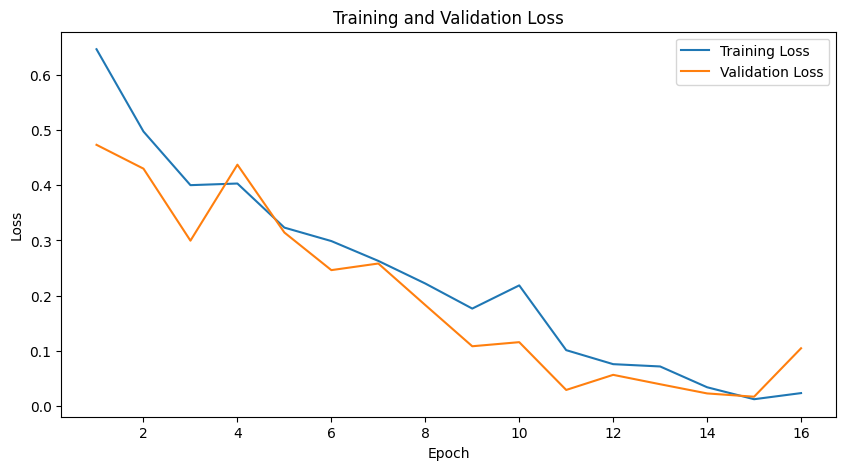

Training Model 2
Epoch [1/16], Training Loss: 0.6184
Validation Loss: 0.4244, Accuracy: 0.7875, Precision: 0.9423, Recall: 0.6125, F1 Score: 0.7424
Epoch [2/16], Training Loss: 0.4732
Validation Loss: 0.4394, Accuracy: 0.7312, Precision: 0.6652, Recall: 0.9313, F1 Score: 0.7760
Epoch [3/16], Training Loss: 0.3816
Validation Loss: 0.3985, Accuracy: 0.8063, Precision: 1.0000, Recall: 0.6125, F1 Score: 0.7597
Epoch [4/16], Training Loss: 0.3359
Validation Loss: 0.3301, Accuracy: 0.8938, Precision: 0.9145, Recall: 0.8688, F1 Score: 0.8910
Epoch [5/16], Training Loss: 0.3118
Validation Loss: 0.2275, Accuracy: 0.9500, Precision: 0.9615, Recall: 0.9375, F1 Score: 0.9494
Epoch [6/16], Training Loss: 0.3413
Validation Loss: 0.2391, Accuracy: 0.9156, Precision: 0.9236, Recall: 0.9062, F1 Score: 0.9148
Epoch [7/16], Training Loss: 0.3113
Validation Loss: 0.3042, Accuracy: 0.8562, Precision: 0.8132, Recall: 0.9250, F1 Score: 0.8655
Epoch [8/16], Training Loss: 0.3156
Validation Loss: 0.3669, Accur

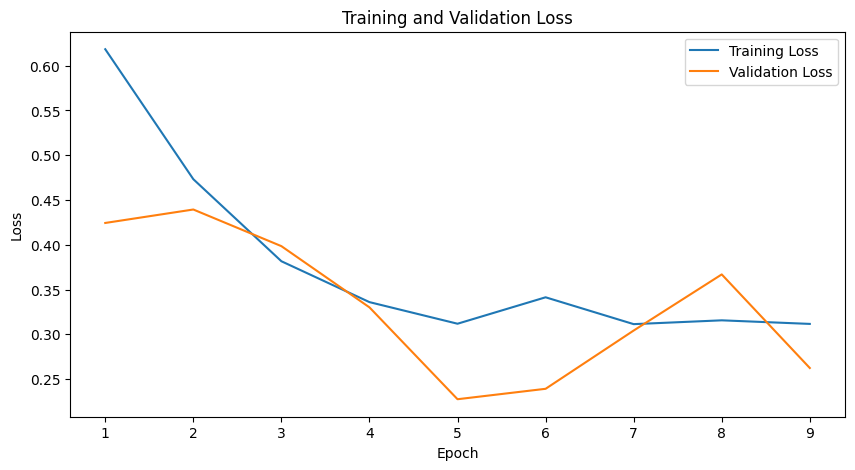

model.safetensors:   0%|          | 0.00/132M [00:00<?, ?B/s]

Best model pushed to the Hugging Face Hub successfully with validation loss: 0.016462385511840694.


In [ ]:
import torch
import torch.nn as nn
from huggingface_hub import PyTorchModelHubMixin

# Define the LSTM model class
class LSTMClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout, model_type="lstm"):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.dropout(output[:, -1, :])
        output = self.fc(output)
        return output

# Set hyperparameters
input_size = tokenizer.vocab_size
hidden_size = 768
num_layers = 2
num_classes = 2
dropout = 0.2
num_epochs = 16
learning_rate = 0.001

# Train models
best_val_loss = float('inf')
best_model_state_dict = None

for model_num in range(2):
    print(f"Training Model {model_num + 1}")

    # Initialize the model
    model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes, dropout)

    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Train the model
    model, val_loss = train_model(model, train_loader, val_loader, num_epochs, device, criterion, optimizer)

    # Check if the current model has the least validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = model.state_dict()

# Save and push the best model to the Hugging Face Hub
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, "lstm-scam-classifier-v1.6.pt")
    # Create a new instance of the best model
    best_model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes, dropout)
    best_model.load_state_dict(best_model_state_dict)
    best_model.push_to_hub("lstm-scam-classifier-v1.6")
    print(f"Best model pushed to the Hugging Face Hub successfully with validation loss: {best_val_loss}.")
else:
    print("No best model found.")

### BiLSTM

Training Model 1
Epoch [1/16], Training Loss: 0.5950
Validation Loss: 0.5227, Accuracy: 0.7250, Precision: 1.0000, Recall: 0.4500, F1 Score: 0.6207
Epoch [2/16], Training Loss: 0.5213
Validation Loss: 0.4491, Accuracy: 0.7969, Precision: 0.9060, Recall: 0.6625, F1 Score: 0.7653
Epoch [3/16], Training Loss: 0.4997
Validation Loss: 0.5952, Accuracy: 0.6875, Precision: 1.0000, Recall: 0.3750, F1 Score: 0.5455
Epoch [4/16], Training Loss: 0.4827
Validation Loss: 0.3739, Accuracy: 0.8063, Precision: 0.9224, Recall: 0.6687, F1 Score: 0.7754
Epoch [5/16], Training Loss: 0.4803
Validation Loss: 0.4245, Accuracy: 0.7969, Precision: 0.8740, Recall: 0.6937, F1 Score: 0.7735
Epoch [6/16], Training Loss: 0.4083
Validation Loss: 0.2428, Accuracy: 0.9062, Precision: 1.0000, Recall: 0.8125, F1 Score: 0.8966
Epoch [7/16], Training Loss: 0.0782
Validation Loss: 0.0092, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [8/16], Training Loss: 0.0456
Validation Loss: 0.0113, Accur

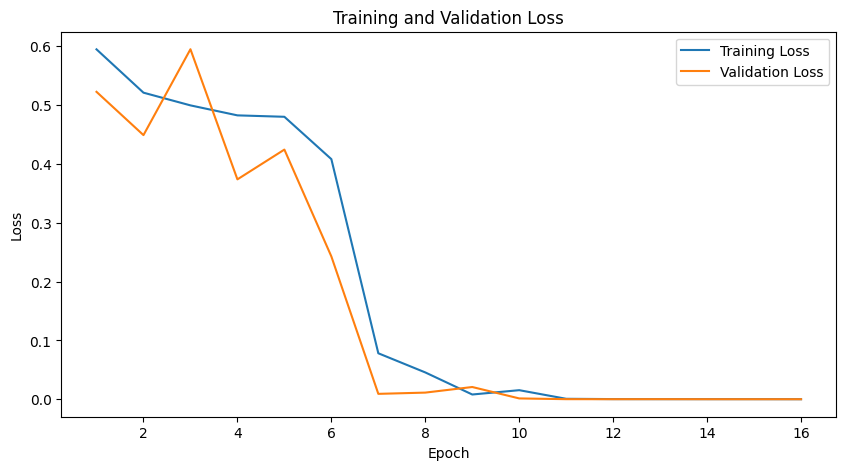

Training Model 2
Epoch [1/16], Training Loss: 0.6791
Validation Loss: 0.4967, Accuracy: 0.7500, Precision: 1.0000, Recall: 0.5000, F1 Score: 0.6667
Epoch [2/16], Training Loss: 0.5170
Validation Loss: 0.4907, Accuracy: 0.7750, Precision: 0.9583, Recall: 0.5750, F1 Score: 0.7188
Epoch [3/16], Training Loss: 0.5149
Validation Loss: 0.4669, Accuracy: 0.7469, Precision: 0.9540, Recall: 0.5188, F1 Score: 0.6721
Epoch [4/16], Training Loss: 0.5309
Validation Loss: 0.5005, Accuracy: 0.6969, Precision: 0.6413, Recall: 0.8938, F1 Score: 0.7467
Epoch [5/16], Training Loss: 0.5609
Validation Loss: 0.5388, Accuracy: 0.6875, Precision: 0.6261, Recall: 0.9313, F1 Score: 0.7487
Epoch [6/16], Training Loss: 0.5646
Validation Loss: 0.5063, Accuracy: 0.7469, Precision: 0.6804, Recall: 0.9313, F1 Score: 0.7863
Epoch [7/16], Training Loss: 0.5168
Validation Loss: 0.4454, Accuracy: 0.8375, Precision: 1.0000, Recall: 0.6750, F1 Score: 0.8060
Epoch [8/16], Training Loss: 0.4462
Validation Loss: 0.3512, Accur

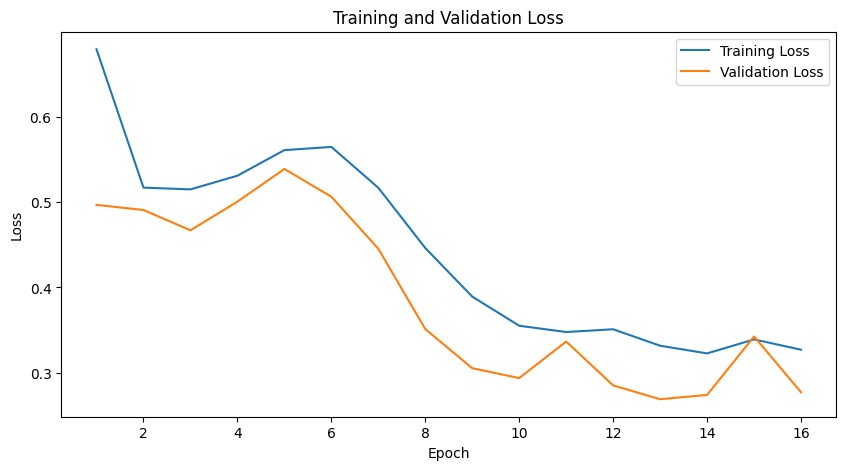

model.safetensors:   0%|          | 0.00/188M [00:00<?, ?B/s]

Best model pushed to the Hugging Face Hub successfully with validation loss: 2.3705923774741676e-05.


In [ ]:
from huggingface_hub import PyTorchModelHubMixin
# Define the LSTM model class
class BiLSTMClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Multiply hidden_size by 2 for BiLSTM
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.dropout(output[:, -1, :])
        output = self.fc(output)
        return output

# Set hyperparameters
input_size = tokenizer.vocab_size
hidden_size = 768
num_layers = 2
num_classes = 2
dropout = 0.2
num_epochs = 16
learning_rate = 0.001

# Initialize variables to track the best model based on validation loss
best_val_loss = float('inf')
best_model_state_dict = None

# Train models
for model_num in range(2):
    print(f"Training Model {model_num + 1}")

    # Initialize the model
    model = BiLSTMClassifier(input_size, hidden_size, num_layers, num_classes, dropout)

    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Train the model
    model, val_loss = train_model(model, train_loader, val_loader, num_epochs, device, criterion, optimizer)

    # Check if the current model has the least validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = model.state_dict()

# Save and push the best model to the Hugging Face Hub
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, "bilstm-scam-classifier-v1.6.pt")
    # Create a new instance of the best model
    best_model = BiLSTMClassifier(input_size, hidden_size, num_layers, num_classes, dropout)
    best_model.load_state_dict(best_model_state_dict)
    best_model.push_to_hub("bilstm-scam-classifier-v1.6")
    print(f"Best model pushed to the Hugging Face Hub successfully with validation loss: {best_val_loss}.")
else:
    print("No best model found.")

### GRU

Training Model 1
Epoch [1/16], Training Loss: 0.4278
Validation Loss: 0.4230, Accuracy: 0.8531, Precision: 1.0000, Recall: 0.7063, F1 Score: 0.8278
Epoch [2/16], Training Loss: 0.0814
Validation Loss: 0.0628, Accuracy: 0.9812, Precision: 0.9873, Recall: 0.9750, F1 Score: 0.9811
Epoch [3/16], Training Loss: 0.0498
Validation Loss: 0.1292, Accuracy: 0.9625, Precision: 0.9302, Recall: 1.0000, F1 Score: 0.9639
Epoch [4/16], Training Loss: 0.0637
Validation Loss: 0.0703, Accuracy: 0.9750, Precision: 0.9524, Recall: 1.0000, F1 Score: 0.9756
Epoch [5/16], Training Loss: 0.0105
Validation Loss: 0.0193, Accuracy: 0.9969, Precision: 1.0000, Recall: 0.9938, F1 Score: 0.9969
Epoch [6/16], Training Loss: 0.0110
Validation Loss: 0.0185, Accuracy: 0.9938, Precision: 0.9938, Recall: 0.9938, F1 Score: 0.9938
Epoch [7/16], Training Loss: 0.0010
Validation Loss: 0.0361, Accuracy: 0.9906, Precision: 1.0000, Recall: 0.9812, F1 Score: 0.9905
Epoch [8/16], Training Loss: 0.0002
Validation Loss: 0.0106, Accur

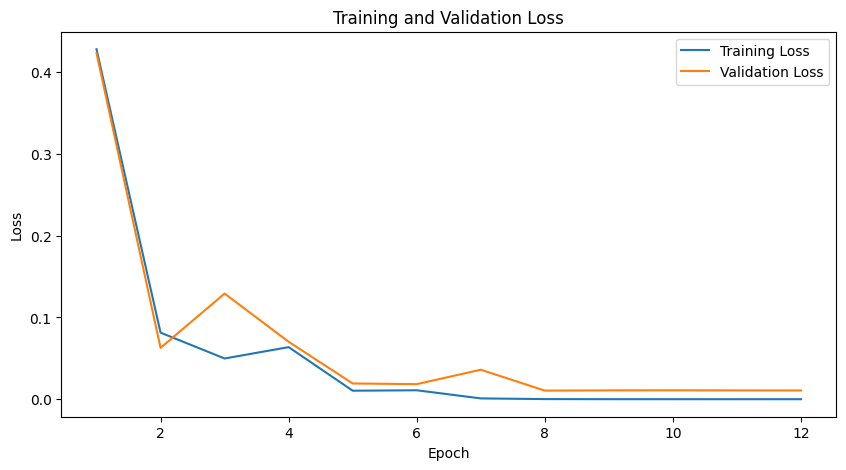

Training Model 2
Epoch [1/16], Training Loss: 0.4530
Validation Loss: 0.2575, Accuracy: 0.8844, Precision: 0.9695, Recall: 0.7937, F1 Score: 0.8729
Epoch [2/16], Training Loss: 0.0818
Validation Loss: 0.0096, Accuracy: 0.9969, Precision: 0.9938, Recall: 1.0000, F1 Score: 0.9969
Epoch [3/16], Training Loss: 0.0034
Validation Loss: 0.0005, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [4/16], Training Loss: 0.0002
Validation Loss: 0.0002, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [5/16], Training Loss: 0.0001
Validation Loss: 0.0002, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [6/16], Training Loss: 0.0001
Validation Loss: 0.0001, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [7/16], Training Loss: 0.0001
Validation Loss: 0.0001, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [8/16], Training Loss: 0.0001
Validation Loss: 0.0001, Accur

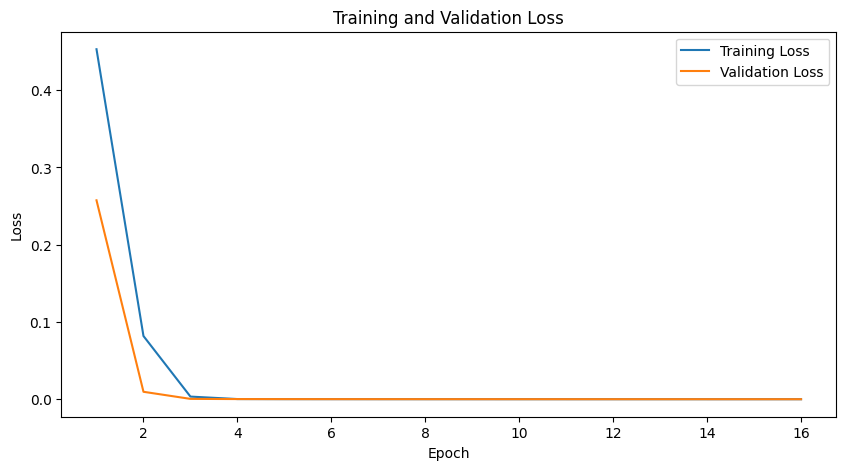

model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

Best model pushed to the Hugging Face Hub successfully with validation loss: 3.0873850982970906e-05.


In [ ]:
from huggingface_hub import PyTorchModelHubMixin

# Define the GRU model class
class GRUClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(GRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.dropout(output[:, -1, :])
        output = self.fc(output)
        return output

# Set hyperparameters
input_size = tokenizer.vocab_size
hidden_size = 768
num_layers = 2
num_classes = 2
dropout = 0.2
num_epochs = 16
learning_rate = 0.001

# Initialize variables to track the best model based on validation loss
best_val_loss = float('inf')
best_model_state_dict = None

# Train models
for model_num in range(2):
    print(f"Training Model {model_num + 1}")

    # Initialize the model
    model = GRUClassifier(input_size, hidden_size, num_layers, num_classes, dropout)

    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Train the model
    model, val_loss = train_model(model, train_loader, val_loader, num_epochs, device, criterion, optimizer)

    # Check if the current model has the least validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = model.state_dict()

# Save and push the best model to the Hugging Face Hub
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, "gru-scam-classifier-v1.6.pt")
    # Create a new instance of the best model
    best_model = GRUClassifier(input_size, hidden_size, num_layers, num_classes, dropout)
    best_model.load_state_dict(best_model_state_dict)
    best_model.push_to_hub("gru-scam-classifier-v1.6")
    print(f"Best model pushed to the Hugging Face Hub successfully with validation loss: {best_val_loss}.")
else:
    print("No best model found.")

### BiGRU

Training Model 1
Epoch [1/20], Training Loss: 0.4375
Validation Loss: 0.1749, Accuracy: 0.9375, Precision: 0.9730, Recall: 0.9000, F1 Score: 0.9351
Epoch [2/20], Training Loss: 0.1050
Validation Loss: 0.0187, Accuracy: 0.9969, Precision: 0.9938, Recall: 1.0000, F1 Score: 0.9969
Epoch [3/20], Training Loss: 0.0263
Validation Loss: 0.0051, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [4/20], Training Loss: 0.0068
Validation Loss: 0.0041, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [5/20], Training Loss: 0.0009
Validation Loss: 0.0008, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [6/20], Training Loss: 0.0002
Validation Loss: 0.0005, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [7/20], Training Loss: 0.0001
Validation Loss: 0.0004, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [8/20], Training Loss: 0.0001
Validation Loss: 0.0003, Accur

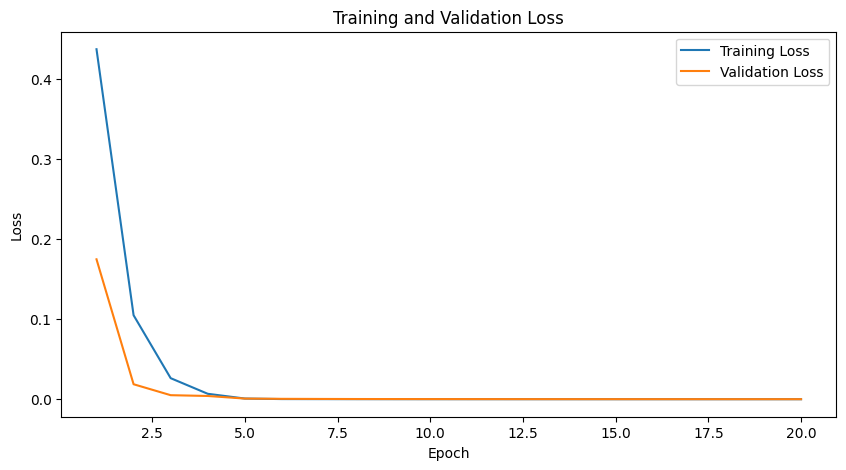

Training Model 2
Epoch [1/20], Training Loss: 0.6005
Validation Loss: 0.3266, Accuracy: 0.8438, Precision: 1.0000, Recall: 0.6875, F1 Score: 0.8148
Epoch [2/20], Training Loss: 0.0999
Validation Loss: 0.1831, Accuracy: 0.9313, Precision: 0.8791, Recall: 1.0000, F1 Score: 0.9357
Epoch [3/20], Training Loss: 0.0180
Validation Loss: 0.0600, Accuracy: 0.9781, Precision: 1.0000, Recall: 0.9563, F1 Score: 0.9776
Epoch [4/20], Training Loss: 0.0276
Validation Loss: 0.0162, Accuracy: 0.9969, Precision: 1.0000, Recall: 0.9938, F1 Score: 0.9969
Epoch [5/20], Training Loss: 0.0093
Validation Loss: 0.0407, Accuracy: 0.9844, Precision: 0.9697, Recall: 1.0000, F1 Score: 0.9846
Epoch [6/20], Training Loss: 0.0017
Validation Loss: 0.0042, Accuracy: 0.9969, Precision: 0.9938, Recall: 1.0000, F1 Score: 0.9969
Epoch [7/20], Training Loss: 0.0003
Validation Loss: 0.0032, Accuracy: 0.9969, Precision: 0.9938, Recall: 1.0000, F1 Score: 0.9969
Epoch [8/20], Training Loss: 0.0002
Validation Loss: 0.0027, Accur

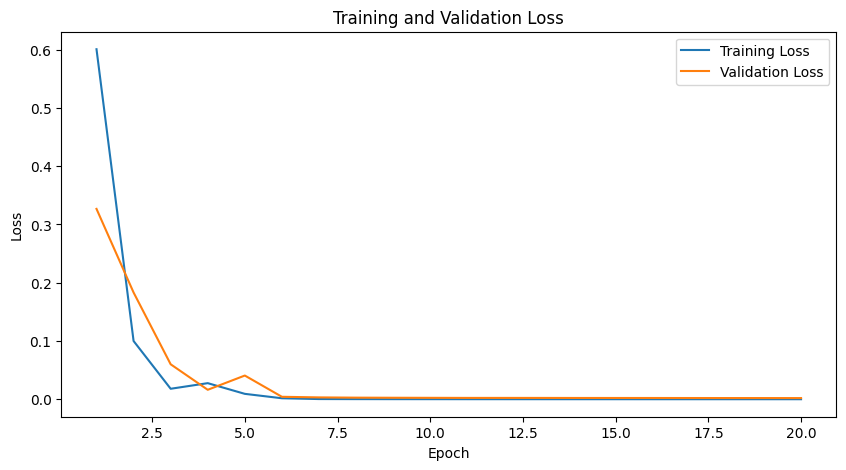

model.safetensors:   0%|          | 0.00/165M [00:00<?, ?B/s]

Best model pushed to the Hugging Face Hub successfully with validation loss: 5.888380371743551e-05.


In [ ]:
from huggingface_hub import PyTorchModelHubMixin

# Define the BiGRU model class
class BiGRUClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(BiGRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Multiply hidden_size by 2 for BiGRU
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.dropout(output[:, -1, :])
        output = self.fc(output)
        return output

# Set hyperparameters
input_size = tokenizer.vocab_size
hidden_size = 768
num_layers = 2
num_classes = 2
dropout = 0.2
num_epochs = 20
learning_rate = 0.001

# Initialize variables to track the best model based on validation loss
best_val_loss = float('inf')
best_model_state_dict = None

# Train models
for model_num in range(2):
    print(f"Training Model {model_num + 1}")

    # Initialize the model
    model = BiGRUClassifier(input_size, hidden_size, num_layers, num_classes, dropout)

    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Train the model
    model, val_loss = train_model(model, train_loader, val_loader, num_epochs, device, criterion, optimizer)

    # Check if the current model has the least validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = model.state_dict()

# Save and push the best model to the Hugging Face Hub
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, "bigru-scam-classifier-v1.6.pt")
    # Create a new instance of the best model
    best_model = BiGRUClassifier(input_size, hidden_size, num_layers, num_classes, dropout)
    best_model.load_state_dict(best_model_state_dict)
    best_model.push_to_hub("bigru-scam-classifier-v1.6")
    print(f"Best model pushed to the Hugging Face Hub successfully with validation loss: {best_val_loss}.")
else:
    print("No best model found.")

### CNN

Training Model 1
Epoch [1/10], Training Loss: 0.1391
Validation Loss: 0.0100, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [2/10], Training Loss: 0.0041
Validation Loss: 0.0027, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [3/10], Training Loss: 0.0022
Validation Loss: 0.0020, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [4/10], Training Loss: 0.0011
Validation Loss: 0.0012, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [5/10], Training Loss: 0.0008
Validation Loss: 0.0010, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [6/10], Training Loss: 0.0005
Validation Loss: 0.0008, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [7/10], Training Loss: 0.0005
Validation Loss: 0.0008, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [8/10], Training Loss: 0.0004
Validation Loss: 0.0005, Accur

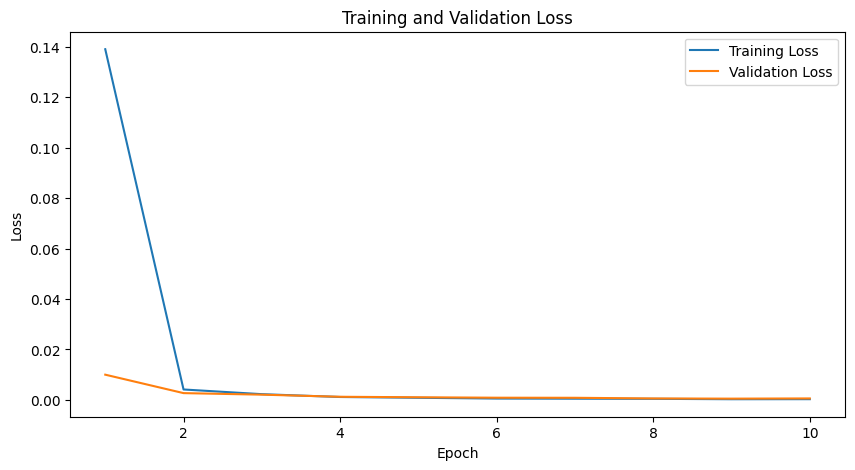

Training Model 2
Epoch [1/10], Training Loss: 0.1103
Validation Loss: 0.0059, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [2/10], Training Loss: 0.0043
Validation Loss: 0.0023, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [3/10], Training Loss: 0.0018
Validation Loss: 0.0019, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [4/10], Training Loss: 0.0009
Validation Loss: 0.0013, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [5/10], Training Loss: 0.0006
Validation Loss: 0.0009, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [6/10], Training Loss: 0.0005
Validation Loss: 0.0007, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [7/10], Training Loss: 0.0003
Validation Loss: 0.0006, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [8/10], Training Loss: 0.0003
Validation Loss: 0.0006, Accur

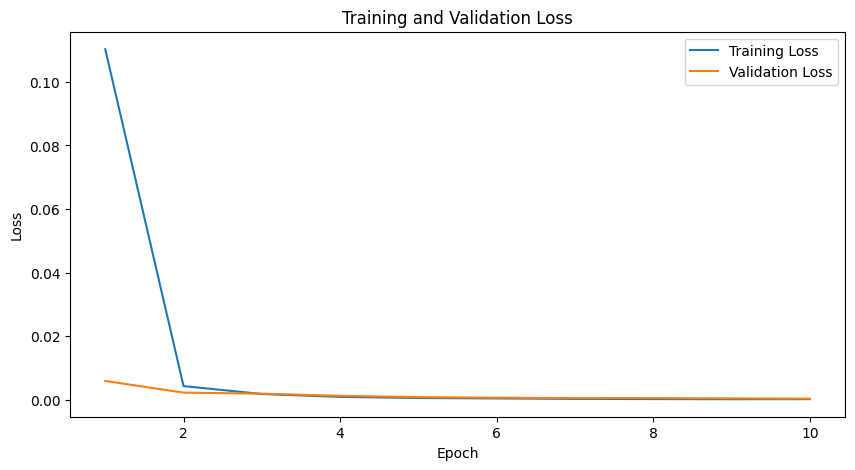

model.safetensors:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

Best model pushed to the Hugging Face Hub successfully with validation loss: 0.00037624516257892535.


In [ ]:
from huggingface_hub import PyTorchModelHubMixin
import torch.nn.functional as F

# Define the CNN model class
class CNNClassifier(nn.Module, PyTorchModelHubMixin):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, num_classes, dropout):
        super(CNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs) for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        output = self.fc(cat)
        return output

# Set hyperparameters
vocab_size = tokenizer.vocab_size
embedding_dim = 128
num_filters = 128
filter_sizes = [3, 4, 5]
num_classes = 2
dropout = 0.2
num_epochs = 10
learning_rate = 0.001

# Initialize variables to track the best model based on validation loss
best_val_loss = float('inf')
best_model_state_dict = None

# Train models
for model_num in range(2):
    print(f"Training Model {model_num + 1}")

    # Initialize the model
    model = CNNClassifier(vocab_size, embedding_dim, num_filters, filter_sizes, num_classes, dropout)

    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Train the model
    model, val_loss = train_model(model, train_loader, val_loader, num_epochs, device, criterion, optimizer)

    # Check if the current model has the least validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = model.state_dict()

# Save and push the best model to the Hugging Face Hub
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, "cnn-scam-classifier-v1.6.pt")

    # Create a new instance of the best model
    best_model = CNNClassifier(vocab_size, embedding_dim, num_filters, filter_sizes, num_classes, dropout)
    best_model.load_state_dict(best_model_state_dict)
    best_model.push_to_hub("cnn-scam-classifier-v1.6")
    print(f"Best model pushed to the Hugging Face Hub successfully with validation loss: {best_val_loss}.")
else:
    print("No best model found.")